# Assignment 4

Deadline: 30.04.2025 12:00 CET

*Buchkov Viacheslav, ID = 24-742-488, viacheslav.buchkov@uzh.ch*\
*Zhiyi Tang, 21-746-763, zhiyi.tang@uzh.ch*\
*Yaqi Wu, 24-746-000, yaqi.wu@uzh.ch*\
*Yangshun Zhou, 24-746-281, yangshun.zhou@uzh.ch*

## Prerequisites: Library imports, data load and initialization of the backtest service

In [1]:
# Standard library imports
import os
import sys
from typing import Optional
from abc import ABC, abstractmethod
from copy import deepcopy

# Third party imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fmin_l_bfgs_b, minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic

# Add the project root directory to Python path
project_root = os.path.dirname(
    os.path.dirname(os.getcwd())
)  # <Change this path if needed>
src_path = os.path.join(
    project_root, "qpmwp-course\\src"
)  # <Change this path if needed>
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from src.helper_functions import load_data_spi
from src.estimation.covariance import Covariance
from src.estimation.expected_return import ExpectedReturn
from src.optimization.optimization import (
    Optimization,
    MeanVariance,
    MinVariance,
)
from src.optimization.optimization_data import OptimizationData
from src.optimization.constraints import Constraints
from src.backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from src.backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
)
from src.backtesting.backtest_data import BacktestData
from src.backtesting.backtest_service import BacktestService
from src.backtesting.backtest import Backtest

In [2]:
# Load data
path_to_data = "../data/"  # <change this to your path to data>

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path=f"{path_to_data}market_data.parquet")

# Instantiate the BacktestData class
# and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.bm_series = load_data_spi(path="../data/")  # <change this if necessary>

In [3]:
# Define rebalancing dates
n_days = 21 * 3
market_data_dates = (
    market_data.index.get_level_values("date").unique().sort_values(ascending=True)
)
rebdates = (
    market_data_dates[market_data_dates > "2015-01-01"][::n_days]
    .strftime("%Y-%m-%d")
    .tolist()
)

In [4]:
# Define the selection item builders.
selection_item_builders = {
    "gaps": SelectionItemBuilder(
        bibfn=bibfn_selection_gaps,
        width=252 * 3,
        n_days=10,
    ),
    "min_volume": SelectionItemBuilder(
        bibfn=bibfn_selection_min_volume,
        width=252,
        min_volume=500_000,
        agg_fn=np.median,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    "return_series": OptimizationItemBuilder(
        bibfn=bibfn_return_series,
        width=252 * 3,
        fill_value=0,
    ),
    "budget_constraint": OptimizationItemBuilder(
        bibfn=bibfn_budget_constraint,
        budget=1,
    ),
    "box_constraints": OptimizationItemBuilder(
        bibfn=bibfn_box_constraints,
        upper=0.1,
    ),
    "size_dep_upper_bounds": OptimizationItemBuilder(
        bibfn=bibfn_size_dependent_upper_bounds,
        small_cap={"threshold": 300_000_000, "upper": 0.02},
        mid_cap={"threshold": 1_000_000_000, "upper": 0.05},
        large_cap={"threshold": 10_000_000_000, "upper": 0.1},
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data=data,
    selection_item_builders=selection_item_builders,
    optimization_item_builders=optimization_item_builders,
    rebdates=rebdates,
)

## 1. Maximum Sharpe Ratio Portfolio

a) 

(6 points)

Complete the `MaxSharpe` class below by implementing your its methods `set_objective` and `solve`.
The `solve` method should implement an iterative algorithm that quickly approximates the "true" maximimum Sharpe ratio portfolio (given the estimates of mean and covariance). This approximation should be done by repeatedly solving a mean-variance optimization problem, where the risk aversion parameter (which scales the covariance matrix) is adjusted in each iteration. The algorithm should terminate after a maximum of 10 iterations.

In this task we implement **six different approaches** for the solution of Maximum Sharpe optimization:
1. **Brute-Force**: this is *NOT* a submission for the task, as it does not satisfy the constraint for 10 iteration, but it will be used to analyze the target solutions.
2. **Golden Section**.
3. Approximation of $f: risk-aversion → Sharpe$ via **Gaussian Process** by optimizing over 10 points.
4. Approximation of $f: risk-aversion → Sharpe$ via **Gaussian Process with Bayesian optimization** (active learning to pick 10 points according to GP-UCB).
5. **Hyperbolic curve fitting** of efficient frontier.
6. **Hyperbolic curve fitting** of efficient frontier with **Active Learning**.

First, we introduce the abstract class for holding all the main methods and specifying the behaviour for all the different approaches used further.

In [5]:
class AbstractMaxSharpe(Optimization, ABC):
    def __init__(
        self,
        max_risk_aversion: float = 100.0,
        max_iterations: int = 10,
        turnover_penalty: Optional[float] = None,
        constraints: Optional[Constraints] = None,
        covariance: Optional[Covariance] = None,
        expected_return: Optional[ExpectedReturn] = None,
        **kwargs,
    ) -> None:
        super().__init__(
            constraints=constraints,
            **kwargs,
        )

        self.max_risk_aversion = max_risk_aversion
        self.max_iterations = max_iterations

        self.turnover_penalty = turnover_penalty

        self.covariance = Covariance() if covariance is None else covariance
        self.expected_return = (
            ExpectedReturn() if expected_return is None else expected_return
        )

        self._mean_variance = None
        self._min_variance = None
        self._optimization_data = None

        self.mu = None
        self.covmat = None

        self._sol_trace = []

    def set_objective(self, optimization_data: OptimizationData) -> None:
        self._optimization_data = optimization_data

        X = optimization_data["return_series"]
        self.covmat = self.covariance.estimate(X=X, inplace=False)
        self.mu = self.expected_return.estimate(X=X, inplace=False)

    def get_mean(self, weights: np.ndarray) -> np.ndarray:
        return self.mu @ weights

    def get_var(self, weights: np.ndarray) -> np.ndarray:
        return weights.T @ self.covmat @ weights

    def get_sharpe_ratio(self, weights: dict[str, np.ndarray]) -> float:
        weights = np.array(list(weights.values()))
        mean = self.get_mean(weights)
        variance = self.get_var(weights)
        return mean, np.sqrt(variance), mean / np.sqrt(variance)

    def _optimize_mv(self, risk_aversion: float) -> [np.ndarray, float]:
        if self.turnover_penalty is not None:
            self._mean_variance = MeanVariance(
                constraints=self.constraints,
                covariance=self.covariance,
                expected_return=self.expected_return,
                risk_aversion=risk_aversion,
                turnover_penalty=self.turnover_penalty,
                x_init=self.params["x_init"],
            )
        else:
            self._mean_variance = MeanVariance(
                constraints=self.constraints,
                covariance=self.covariance,
                expected_return=self.expected_return,
                risk_aversion=risk_aversion,
                x_init=self.params["x_init"],
            )

        self._mean_variance.set_objective(self._optimization_data)
        self._mean_variance.solve()

        opt_weights = self._mean_variance.results["weights"]
        # Even though this way of returning output is a bit messy,
        # it saves up iterations by just providing all the info needed for all optimizers.
        return opt_weights, *self.get_sharpe_ratio(opt_weights)

    @abstractmethod
    def _run_search(self, max_ra: float, max_iter: int) -> tuple[float, np.ndarray]:
        raise NotImplementedError

    def solve(self) -> None:
        opt_ra, opt_weights = self._run_search(
            self.max_risk_aversion, self.max_iterations
        )
        self.results.update(
            {
                "risk-aversion": opt_ra,
                "weights": opt_weights,
                "status": True,
            }
        )

    def get_error_trace(self, true_point: float) -> np.ndarray:
        return (np.array(self._sol_trace) - true_point) ** 2

#### 1. Brute-Force.

Here we just iterate over `num_points` optimizations and find the optimum via `argmax`. This is *NOT* a solution for the assignment, but rather a way to empirically check that our advanced optimizations are working correctly and converging.

In [6]:
class MaxSharpeBruteForce(AbstractMaxSharpe):
    def __init__(
        self,
        num_points: int = 1_000,
        max_risk_aversion: float = 100.0,
        max_iterations: int = 10,
        turnover_penalty: Optional[float] = None,
        constraints: Optional[Constraints] = None,
        covariance: Optional[Covariance] = None,
        expected_return: Optional[ExpectedReturn] = None,
        **kwargs,
    ) -> None:
        super().__init__(
            max_risk_aversion=max_risk_aversion,
            max_iterations=max_iterations,
            turnover_penalty=turnover_penalty,
            constraints=constraints,
            covariance=covariance,
            expected_return=expected_return,
            **kwargs,
        )

        self.num_points = num_points

        self._mus = []
        self._vols = []

    def _run_search(
        self, max_ra: float, max_iter: int
    ) -> tuple[float, dict[str, np.ndarray]]:
        self._points = np.linspace(
            0, max_ra, self.num_points
        )  # Risk-aversion is always non-negative

        self._weights = []
        self._sharpes = []
        for point in tqdm(self._points):
            weights, mu, vol, sharpe = self._optimize_mv(point)
            self._weights.append(weights)
            self._sharpes.append(sharpe)
            self._mus.append(mu)
            self._vols.append(vol)

        opt_point_idx = np.argmin(self._sharpes)

        return self._points[opt_point_idx], self._weights[opt_point_idx]

    @property
    def weights(self) -> np.ndarray | None:
        return self._weights

    @property
    def sharpes(self) -> np.ndarray | None:
        return self._sharpes

    @property
    def means(self) -> np.ndarray | None:
        return self._mus

    @property
    def vols(self) -> np.ndarray | None:
        return self._vols

    @property
    def risk_aversions(self) -> np.ndarray | None:
        return self._points

In [7]:
bs.optimization = MaxSharpeBruteForce(
    covariance=Covariance(method="pearson"),
    expected_return=ExpectedReturn(method="geometric"),
    solver_name="cvxopt",  # <change this to your preferred solver>
    # <add any other parameters you need, e.g., number of iterations, tolerance, etc.>
)
bs.prepare_rebalancing("2015-01-02")
bs.optimization.set_objective(bs.optimization_data)
bs.optimization.solve()
bs.optimization.results

100%|██████████| 1000/1000 [00:15<00:00, 62.66it/s]


{'risk-aversion': np.float64(100.0),
 'weights': {'102': 1.699450487422467e-08,
  '103': 5.4908746237851574e-08,
  '104': 0.011508094779309804,
  '111': 0.009012316591512566,
  '113': 4.526353703840216e-09,
  '122': 1.3570887876030983e-08,
  '125': 0.019999990495123413,
  '127': 0.019999991053930948,
  '128': 0.01999995574639739,
  '13': 1.1514098849001015e-08,
  '139': 6.476836464042193e-08,
  '141': 4.431439876716231e-08,
  '142': 1.3695184583430952e-08,
  '148': 0.01999994807474256,
  '149': 2.2352488904129725e-08,
  '154': 0.019999463528967157,
  '159': 0.01999999052156961,
  '161': 0.019999919532805367,
  '169': 0.0199999867774099,
  '175': 0.0199999824250015,
  '176': 0.019744532816349337,
  '177': 0.019999969272171944,
  '184': 0.019999978568361304,
  '185': 0.01999997951748959,
  '187': 2.3540952276987867e-08,
  '189': 1.1819250959008252e-07,
  '191': 0.01999998026934668,
  '197': 2.720917105924027e-07,
  '2': 0.01999998907766371,
  '200': 0.009550702849062611,
  '201': 3.55805

In [8]:
bf_means = bs.optimization.means
bf_vols = bs.optimization.vols

In [9]:
ra = np.array(bs.optimization.risk_aversions)
sr = np.array(bs.optimization.sharpes)

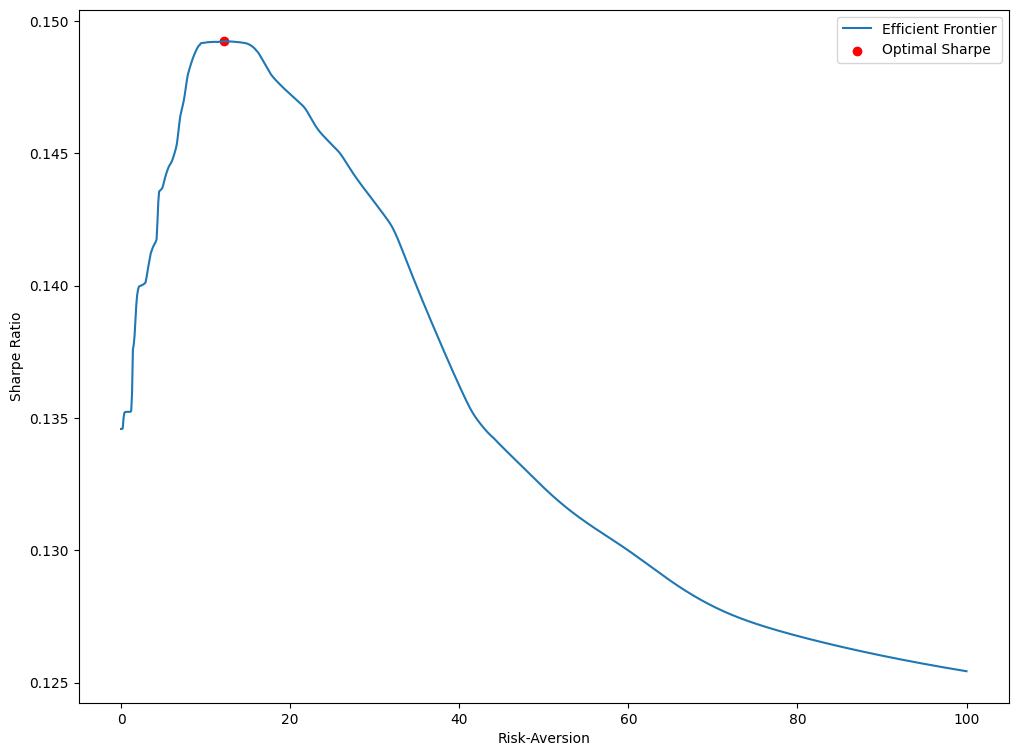

In [10]:
plt.figure(figsize=(12, 9))
plt.plot(ra, sr, label="Efficient Frontier")
sr_opt_idx = np.argmax(sr)
plt.scatter(ra[sr_opt_idx], sr[sr_opt_idx], c="r", label="Optimal Sharpe")
plt.legend()
plt.xlabel("Risk-Aversion")
plt.ylabel("Sharpe Ratio")
plt.show()

We can note that the $f: risk-aversion → Sharpe$ function resembles a concave function, while being not exactly smooth due to numerical instability of: a) solvers; b) Sharpe ratio as a measure. Further we would want to use this concavity (convexity) for improved optimization.

#### 2. Golden Section.

We can be certain that on the domain of admissable (non-negative) risk-aversions our target $f: risk-aversion → Sharpe$ is unimodal, meaning that it has only one mode → one distinct maximum value. Indeed, for every set of means and volatilities we would obtain a unique optimal Sharpe, as the point of tangency (under no short-selling) with CAL is unique.

However, the efficient frontier for $N > 2$ assets is not a known (closed-out) function, because in general the mean-variance tradeoff is monotone, but the second derivative might be arbitrary.

Therefore, we can apply a simple method of finding an optimum for unimodal function via efficiently picking the next point, where we should optimize mean-variance portfolio. In analysis one can show that this optimal point is given by the golden section split under $\phi = \frac{1 + \sqrt{5}}{2}$. Therefore, we can restrict the number of iterations by 10 to obtain close enough solution to the true optimum.

In [11]:
class MaxSharpeGoldenSection(AbstractMaxSharpe):
    GS_CONST = (1 + np.sqrt(5)) / 2

    def __init__(
        self,
        max_risk_aversion: float = 100.0,
        max_iterations: int = 10,
        verbose: bool = True,
        turnover_penalty: Optional[float] = None,
        constraints: Optional[Constraints] = None,
        covariance: Optional[Covariance] = None,
        expected_return: Optional[ExpectedReturn] = None,
        **kwargs,
    ) -> None:
        super().__init__(
            max_risk_aversion=max_risk_aversion,
            max_iterations=max_iterations,
            turnover_penalty=turnover_penalty,
            constraints=constraints,
            covariance=covariance,
            expected_return=expected_return,
            **kwargs,
        )

        self.verbose = verbose

    def _run_search(self, max_ra: float, max_iter: int) -> tuple[float, np.ndarray]:
        min_ra = 0  # Risk-aversion is always non-negative

        left_ra = min_ra + (max_ra - min_ra) / (self.GS_CONST + 1)
        right_ra = max_ra - (max_ra - min_ra) / (self.GS_CONST + 1)
        left_weights, _, _, left_sr = self._optimize_mv(left_ra)
        right_weights, _, _, right_sr = self._optimize_mv(right_ra)
        for _ in tqdm(
            range(max_iter), disable=not self.verbose, desc="Golden Section Search"
        ):
            if left_sr > right_sr:
                max_ra = right_ra
                right_ra = left_ra
                right_sr = left_sr
                left_ra = min_ra + (max_ra - min_ra) / (self.GS_CONST + 1)
                left_weights, _, _, left_sr = self._optimize_mv(left_ra)
            else:
                min_ra = left_ra
                left_ra = right_ra
                left_sr = right_sr
                right_ra = max_ra - (max_ra - min_ra) / (self.GS_CONST + 1)
                right_weights, _, _, right_sr = self._optimize_mv(right_ra)

            if left_sr <= right_sr:
                self._sol_trace.append(right_ra)
            else:
                self._sol_trace.append(left_ra)

        if left_sr <= right_sr:
            opt_ra = right_ra
            opt_weights = right_weights
        else:
            opt_ra = left_ra
            opt_weights = left_weights

        return opt_ra, opt_weights

In [12]:
bs.optimization = MaxSharpeGoldenSection(
    covariance=Covariance(method="pearson"),
    expected_return=ExpectedReturn(method="geometric"),
    solver_name="cvxopt",  # <change this to your preferred solver>
    # <add any other parameters you need, e.g., number of iterations, tolerance, etc.>
)
bs.prepare_rebalancing("2015-01-02")
bs.optimization.set_objective(bs.optimization_data)
bs.optimization.solve()
bs.optimization.results

Golden Section Search: 100%|██████████| 10/10 [00:00<00:00, 55.64it/s]


{'risk-aversion': np.float64(12.269241877260763),
 'weights': {'102': 1.0647795081150917e-07,
  '103': 6.833982932442565e-08,
  '104': 0.019999648407619457,
  '111': 0.018988575430585814,
  '113': 2.1793874553147394e-08,
  '122': 1.9305516206533883e-07,
  '125': 0.01999989790841647,
  '127': 0.019999879959771396,
  '128': 0.01999982756326809,
  '13': 1.494297570121157e-07,
  '139': 0.01999985480184441,
  '141': 0.019999914098335864,
  '142': 9.420110648815137e-08,
  '148': 0.019999903674760226,
  '149': 9.215400227849293e-08,
  '154': 1.6259231883735657e-07,
  '159': 0.01999969041967226,
  '161': 0.006894954858912076,
  '169': 0.019999911849393297,
  '175': 0.0199995816892402,
  '176': 0.019998501401455565,
  '177': 7.674339705541955e-08,
  '184': 0.019999752020049905,
  '185': 0.019999668585819207,
  '187': 1.3007972769111107e-07,
  '189': 3.678654584963181e-07,
  '191': 1.2198778637700048e-06,
  '197': 3.5570174721366213e-07,
  '2': 0.019998754946274174,
  '200': 0.019998919981269785

Let's compare the obtained result with the Brute-Force that is considered to be the "ground truth" in this setting.

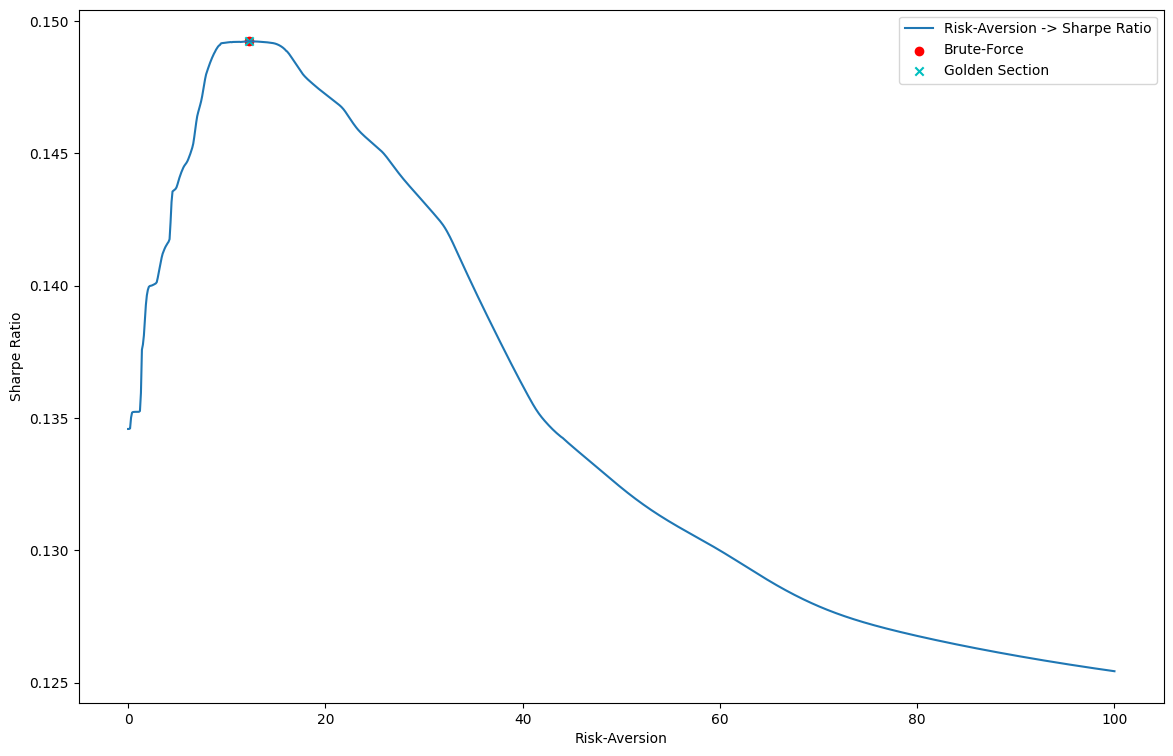

In [13]:
gs_ra = bs.optimization.results["risk-aversion"]
_, _, _, sr_ra = bs.optimization._optimize_mv(gs_ra)

plt.figure(figsize=(14, 9))
plt.plot(ra, sr, label="Risk-Aversion -> Sharpe Ratio")
sr_opt_idx = np.argmax(sr)
plt.scatter(ra[sr_opt_idx], sr[sr_opt_idx], c="r", label="Brute-Force")
plt.scatter(gs_ra, sr_ra, c="c", label="Golden Section", marker="x")
plt.legend()
plt.xlabel("Risk-Aversion")
plt.ylabel("Sharpe Ratio")
plt.show()

We see that our optimal solution indeed corresponds almost the same point as the Brute-Force solution, meaning that **we are able to converge in 10 iterations as good as excessive Brute-Force does in 1_000 steps**!

#### 3. Gaussian Process Fitting.

The next idea that arises is trying to use so-called "Model-Based Approach", i.e. trying to learn the dependence first, and then obtain the optimum from the fitted function.

For the purposes of fitting a non-linear dependence with sufficiently smooth general function, one might find Gaussian Process Regression to be a very useful tool. Being the **distribution over functions**, Gaussian Process can be considered in this setting as if we say that all the efficient frontiers in the world possible for these assets are distributed as some functions, where each efficient frontier has some unknown probability to be a true one. Therefore, **Gaussian Process will be able to fit the probabilitic model for all possible efficient frontiers**, given the sampled points.

Further, we use the Gaussian Process to optimize for risk-aversion parameter and obtain the Maximum Sharpe portfolio. Please note that in this setting it can be done **for any set of constraints and additional penalties**, as we are fitting some unknown distribution over the function space.

We choose $RationalQuadratic$ kernel, because the maximum Sharpe function can be locally and globally smooth, but having different speed of growth (second derivative), which RQ generalizes well enough for, being an infinite sum of RBF kernels, which allows to control smoothness better.

In [14]:
class MaxSharpeGP(AbstractMaxSharpe):
    def __init__(
        self,
        max_risk_aversion: float = 100.0,
        max_iterations: int = 10,
        turnover_penalty: Optional[float] = None,
        constraints: Optional[Constraints] = None,
        covariance: Optional[Covariance] = None,
        expected_return: Optional[ExpectedReturn] = None,
        **kwargs,
    ) -> None:
        super().__init__(
            max_risk_aversion=max_risk_aversion,
            max_iterations=max_iterations,
            turnover_penalty=turnover_penalty,
            constraints=constraints,
            covariance=covariance,
            expected_return=expected_return,
            **kwargs,
        )

        self.gpr = GaussianProcessRegressor(
            kernel=RationalQuadratic(),
            n_restarts_optimizer=12,
            random_state=12,
        )

    def get_solution(self, max_ra: float) -> tuple[float, np.ndarray]:
        ra_init = 0

        def objective(x: np.array):
            x = np.array(x).reshape(-1, 1)
            mean, _ = self.gpr.predict(x, return_std=True)
            return -mean.item()

        np.random.seed(12)
        result = minimize(objective, x0=ra_init, bounds=[(0, max_ra)])
        ra_opt = result.x.item()

        weights_opt, _, _, sharpe = self._optimize_mv(ra_opt)
        self.optimal_sharpe = sharpe

        return ra_opt, weights_opt

    def _run_search(self, max_ra: float, max_iter: int) -> tuple[float, np.ndarray]:
        ra_space = np.linspace(
            0, max_ra, max_iter - 1
        )  # Risk-aversion is always non-negative

        sharpes = []
        for ra in ra_space:
            weights, _, _, sharpe = self._optimize_mv(ra)
            sharpes.append(sharpe)

        self.gpr.fit(ra_space.reshape(-1, 1), sharpes)

        ra_opt, weights_opt = self.get_solution(max_ra)

        return ra_opt, weights_opt

In [15]:
bs.optimization = MaxSharpeGP(
    covariance=Covariance(method="pearson"),
    expected_return=ExpectedReturn(method="geometric"),
    solver_name="cvxopt",  # <change this to your preferred solver>
    # <add any other parameters you need, e.g., number of iterations, tolerance, etc.>
)
bs.prepare_rebalancing("2015-01-02")
bs.optimization.set_objective(bs.optimization_data)
bs.optimization.solve()
bs.optimization.results

{'risk-aversion': 15.498008740523975,
 'weights': {'102': 4.5889005368246586e-07,
  '103': 3.3177266388053827e-07,
  '104': 0.019996756141333488,
  '111': 0.014213087735567412,
  '113': 1.0974503979263079e-07,
  '122': 6.191051499001767e-07,
  '125': 0.01999953203745489,
  '127': 0.01999944053886312,
  '128': 0.01999906634905407,
  '13': 5.189717125339509e-07,
  '139': 0.019998258111253855,
  '141': 0.019999336346880694,
  '142': 3.8156965775916214e-07,
  '148': 0.019999461884372346,
  '149': 4.4876851258885473e-07,
  '154': 8.433979971461209e-07,
  '159': 0.01999901528786067,
  '161': 0.008335029373346193,
  '169': 0.01999953500045124,
  '175': 0.01999835728369888,
  '176': 0.01996757112839623,
  '177': 4.689594581459042e-07,
  '184': 0.01999893541011703,
  '185': 0.01999822259865933,
  '187': 5.41996267603684e-07,
  '189': 9.332764467980683e-07,
  '191': 0.003957786510999936,
  '197': 1.1416266727842907e-06,
  '2': 0.019998011595239135,
  '200': 0.019970911202511585,
  '201': 0.01958

In [16]:
bs.optimization.gpr

GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1),
                         n_restarts_optimizer=12, random_state=12)

/Users/buchkovv/PycharmProjects/uzh/qpmp/qpmwp-course/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/buchkovv/PycharmProjects/uzh/qpmp/qpmwp-course/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/buchkovv/PycharmProjects/uzh/qpmp/qpmwp-course/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_


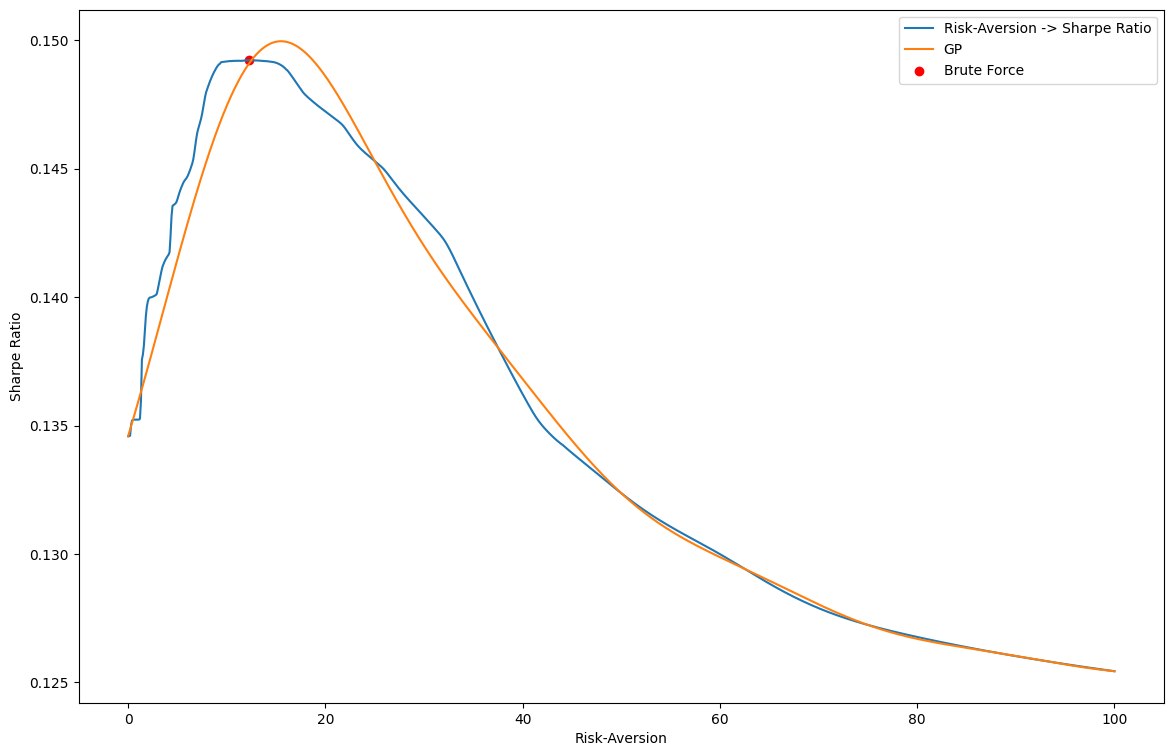

In [17]:
plt.figure(figsize=(14, 9))
plt.plot(ra, sr, label="Risk-Aversion -> Sharpe Ratio")
plt.plot(ra, bs.optimization.gpr.predict(ra.reshape(-1, 1)), label="GP")
sr_opt_idx = np.argmax(sr)
plt.scatter(ra[sr_opt_idx], sr[sr_opt_idx], c="r", label="Brute Force")
plt.legend()
plt.xlabel("Risk-Aversion")
plt.ylabel("Sharpe Ratio")
plt.show()

We can see that in only 10 iteration Gaussian Process is able to do a pretty good job of fitting this complex dependence (even though our upper bound is quite far from optimum, and thus we have a lot of redundant points). However, the function appears shifted and not extremely precise around the optimum. This is **due to sampling points equidistantly, thus, having some redundant fits in the high and irrelevant values of risk-aversion**. Let's fix it in the next iteration.

#### 4. Gaussian Process Active Learning.

As was mentioned above, the main issue of previous optimization is restricted number of points for fitting, some of which appear to be lying in irrelevant sub-domains, where we have little interest of fitting the function, as it is far from optimum.

In this case the best approach for our task is application of the **Active Learning** approach. It is a technique of Bayesian Optimization, where we **use model uncertainty** to pick the points at which we should sample next iteration out of our **restricted budget set of 10 iterations**. The idea is simple - there is always a trade-off between two notions. In general, we want to spend this small budged to sample close to potential optimum to make more precise bet on where the maximum is contained. However, it might be so that our current fitted curve is quite imperfect - there might be some regions, where we didn't see any relevant points and cannot claim the dependence of $x$ to $y$. These regions are characterized by **large epistemic (model) uncertainty**, thus, we should sample more points there to get more precise fit. The Bayesian Optimization techniques aim to balance this trade-off.

The idea of **large epistemic uncertainty** sampling is known based on balancing **exploration versus exploitation** and can be summarized in the following picture:

![Image_1.png](Image_1.png)

*Picture Source: Prof. Dr. Andreas Krause, Learning & Adaptive Systems Group, ETH Zurich*

At start (Picture 1) we have equal uncertainty (grey area) across all points of risk-aversion, as we do not know anything about optimality yet (we haven't run a single optimization). Then we **receive the information about regions as we sample the data from these intervals**. Basically, we are saying that we want to construct a mathematically sound algorithm for decision on where to sample. Indeed, if we obtained Sharpe for risk-aversion of 12, it probably would benifit us way more to sample risk-aversion of 20 rather than 12.5.
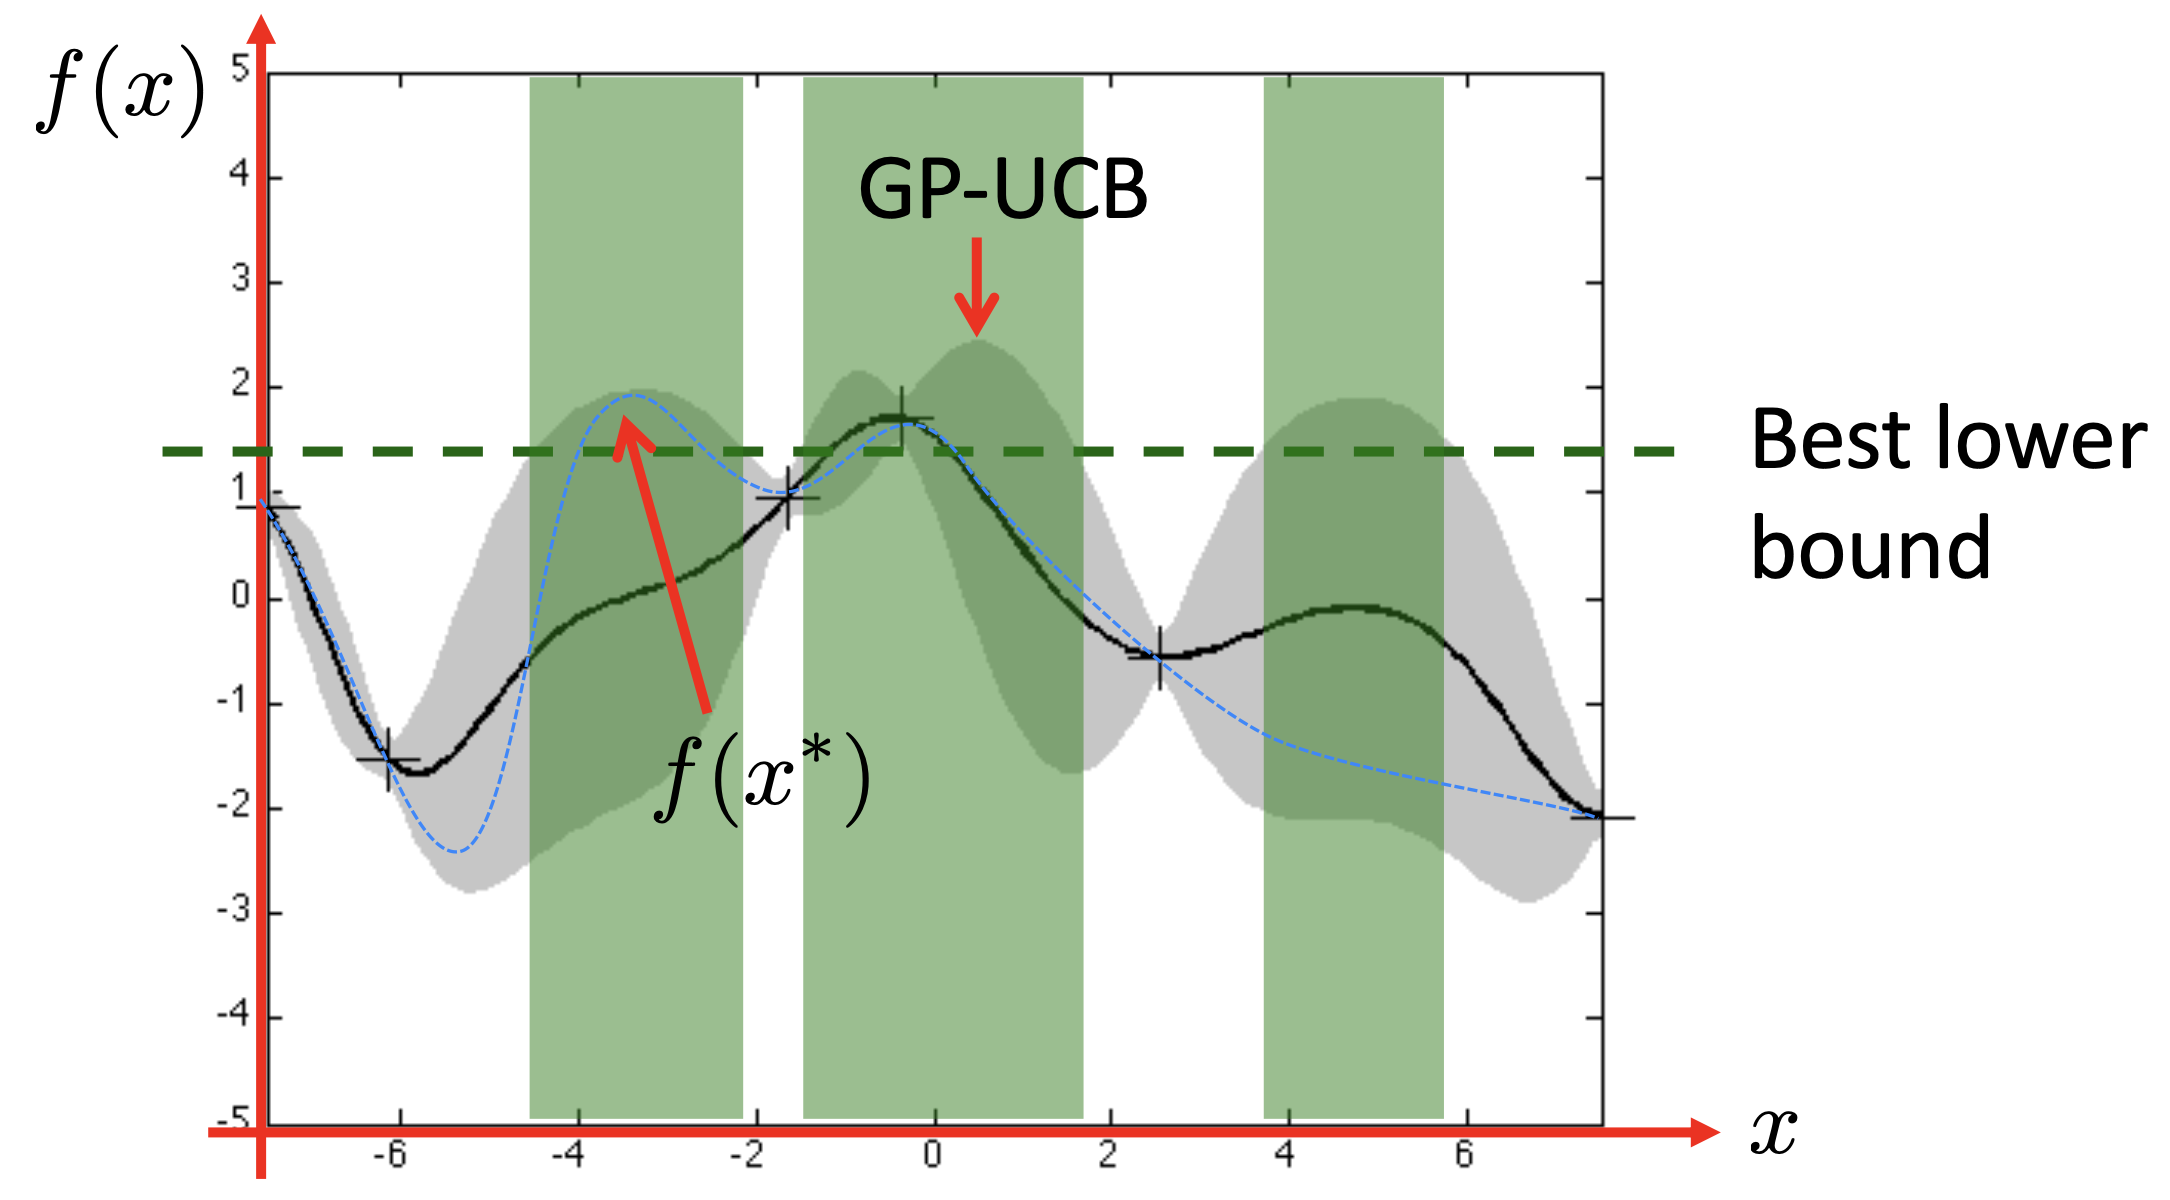
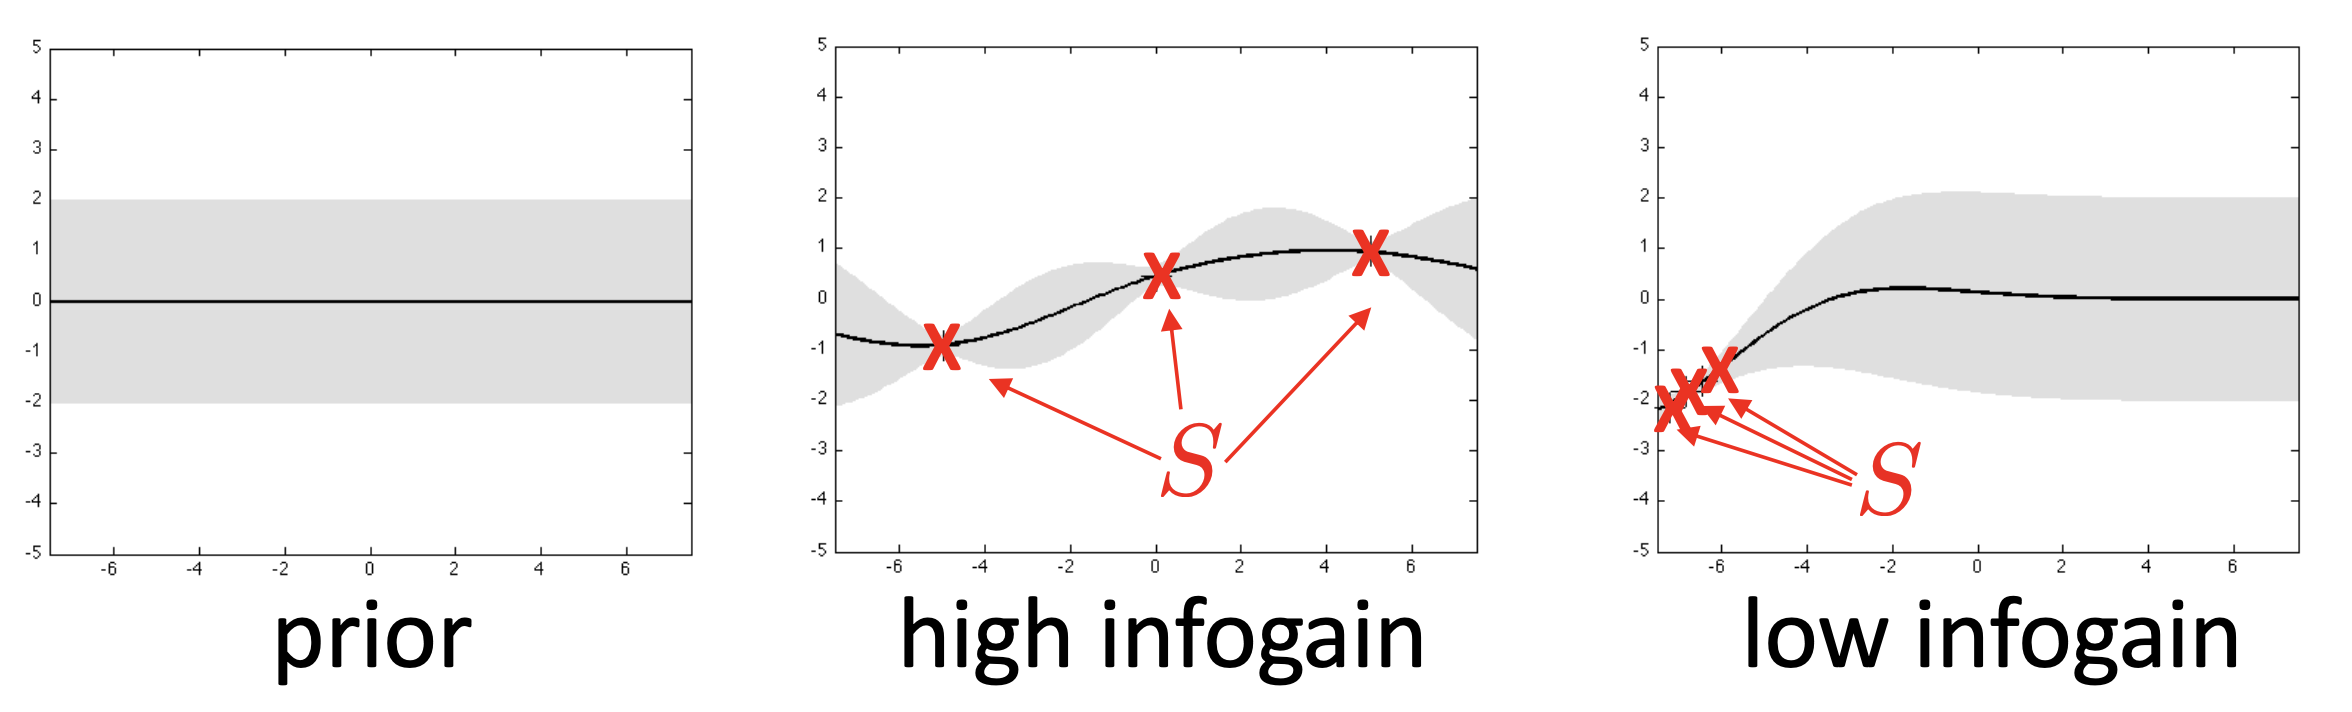

Finally, in optimization we use Hoeffding Inequality to establish the exploration-exploitation trade-off and combine the potentially high value (our potential maximum) with the high uncertainty (potentially good region to explore for an even better maximum) and obtain GP-UCB algorithm.

![Image_2.png](Image_2.png)

*Picture Source: Prof. Dr. Andreas Krause, Learning & Adaptive Systems Group, ETH Zurich*

Green areas show our regions of potential maximums that we want to explore - either our estimate of the value there is high or the uncertainty is relatively high.

Note that in this approach we do not make any assumptions on the behaviour of the target function $f: risk-aversion → Sharpe$ - neither the globality of the optimum (it can handle local optima) nor the unimodality (even though it is crucial for the way we find the optimum after fitting, in more advanced setting the GP fitting part would still stay the same - just the final `get_solution` function would change).

In [18]:
class MaxSharpeGPActiveLearn(AbstractMaxSharpe):
    def __init__(
        self,
        max_risk_aversion: float = 100.0,
        max_iterations: int = 10,
        turnover_penalty: Optional[float] = None,
        acq_beta: float = 1.96,
        constraints: Optional[Constraints] = None,
        covariance: Optional[Covariance] = None,
        expected_return: Optional[ExpectedReturn] = None,
        **kwargs,
    ) -> None:
        super().__init__(
            max_risk_aversion=max_risk_aversion,
            max_iterations=max_iterations,
            turnover_penalty=turnover_penalty,
            constraints=constraints,
            covariance=covariance,
            expected_return=expected_return,
            **kwargs,
        )

        self.acq_beta = acq_beta

        self.gpr = GaussianProcessRegressor(
            kernel=RationalQuadratic(),
            n_restarts_optimizer=12,
            random_state=12,
        )

        self._domain_ra = (0, max_risk_aversion)

        self.previous_points = []
        self.previous_targets = []
        self.previous_weights = []

        self.optimal_sharpe = None

    def next_recommendation(self) -> np.ndarray:
        return self.optimize_acquisition_function().item()

    def optimize_acquisition_function(self) -> np.ndarray:
        def objective(x: np.array):
            return -self.acquisition_function(x)

        f_values = []
        x_values = []

        np.random.seed(12)
        # Restarts the optimization 20 times and pick best solution
        for _ in range(20):
            x_init = self._domain_ra[0] + (
                self._domain_ra[1] - self._domain_ra[0]
            ) * np.random.rand(1)
            result = fmin_l_bfgs_b(
                objective,
                x0=np.array([x_init]),
                bounds=[self._domain_ra],
                approx_grad=True,
            )
            x_values.append(result[0])
            f_values.append(result[1])

        ind = np.argmin(f_values)
        return x_values[ind]

    def acquisition_function(self, x: np.ndarray) -> np.ndarray:
        mu_f, sigma_f = self.gpr.predict(x.reshape(-1, 1), return_std=True)

        return (mu_f + sigma_f * self.acq_beta)[0]

    def add_data_point(
        self, x: float, acq_fn_val: float, weights: dict[str, np.ndarray]
    ) -> None:
        self.previous_points.append(x)
        self.previous_targets.append(acq_fn_val)
        self.previous_weights.append(weights)

        self.gpr.fit(
            np.array(self.previous_points).reshape(-1, 1),
            np.array(self.previous_targets),
        )

    def get_solution(self) -> tuple[float, np.ndarray]:
        idx = np.argmax(np.array(self.previous_targets))
        ra_init = self.previous_points[idx]

        def objective(x: np.array):
            x = np.array(x).reshape(-1, 1)
            mean, _ = self.gpr.predict(x, return_std=True)
            return -mean.item()

        np.random.seed(12)
        result = minimize(objective, x0=ra_init, bounds=[self._domain_ra])
        ra_opt = result.x.item()

        weights_opt, _, _, sharpe = self._optimize_mv(ra_opt)
        self.optimal_sharpe = sharpe

        return ra_opt, weights_opt

    def _run_search(self, max_ra: float, max_iter: int) -> tuple[float, np.ndarray]:
        for _ in range(
            max_iter - 1
        ):  # -1 as one more optim is called in get_solution() after the last iteration
            ra = self.next_recommendation()

            weights, _, _, sharpe = self._optimize_mv(ra)

            self.add_data_point(ra, sharpe, weights)

        ra_opt, weights_opt = self.get_solution()

        return ra_opt, weights_opt

In [19]:
bs.optimization = MaxSharpeGPActiveLearn(
    covariance=Covariance(method="pearson"),
    expected_return=ExpectedReturn(method="geometric"),
    solver_name="cvxopt",  # <change this to your preferred solver>
    # <add any other parameters you need, e.g., number of iterations, tolerance, etc.>
)
bs.prepare_rebalancing("2015-01-02")
bs.optimization.set_objective(bs.optimization_data)
bs.optimization.solve()
bs.optimization.results

{'risk-aversion': 12.787579443461915,
 'weights': {'102': 1.8131290051750173e-07,
  '103': 1.2270522436954314e-07,
  '104': 0.01999931812676394,
  '111': 0.01802383923623905,
  '113': 3.973482869409893e-08,
  '122': 2.9500947530767296e-07,
  '125': 0.019999812340455322,
  '127': 0.01999977788405274,
  '128': 0.01999968632733222,
  '13': 2.389922718403556e-07,
  '139': 0.019999685993450783,
  '141': 0.019999832383940427,
  '142': 1.620230237748458e-07,
  '148': 0.019999818235049434,
  '149': 1.6149733761139946e-07,
  '154': 2.7922511283005216e-07,
  '159': 0.019999500302949037,
  '161': 0.006558212528861856,
  '169': 0.019999832116329865,
  '175': 0.019999297628096612,
  '176': 0.019997484015199216,
  '177': 1.3996365752272237e-07,
  '184': 0.01999957405168388,
  '185': 0.01999936650884402,
  '187': 2.282674751711651e-07,
  '189': 6.017123946583296e-07,
  '191': 2.3916303239295247e-06,
  '197': 6.568101911457578e-07,
  '2': 0.019998552681226342,
  '200': 0.019998099192705628,
  '201': 0

/Users/buchkovv/PycharmProjects/uzh/qpmp/qpmwp-course/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/buchkovv/PycharmProjects/uzh/qpmp/qpmwp-course/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/buchkovv/PycharmProjects/uzh/qpmp/qpmwp-course/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_


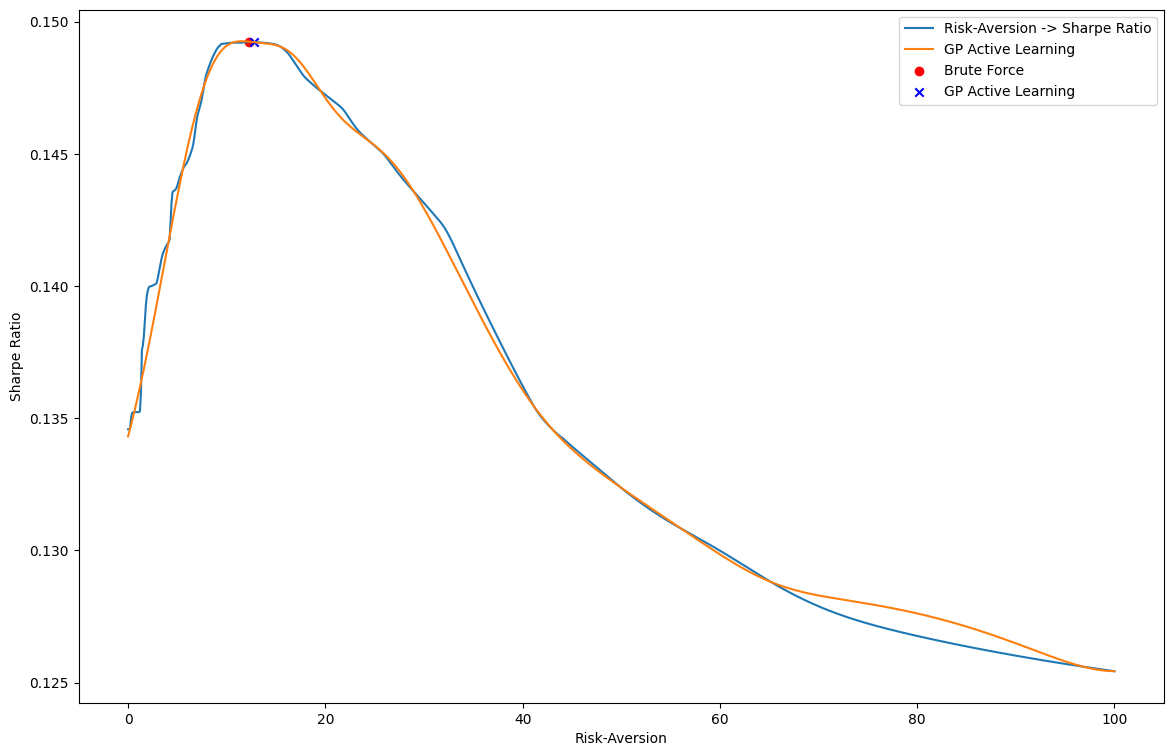

In [20]:
plt.figure(figsize=(14, 9))
plt.plot(ra, sr, label="Risk-Aversion -> Sharpe Ratio")
plt.plot(ra, bs.optimization.gpr.predict(ra.reshape(-1, 1)), label="GP Active Learning")
plt.scatter(ra[sr_opt_idx], sr[sr_opt_idx], c="r", label="Brute Force")
plt.scatter(
    bs.optimization.results["risk-aversion"],
    bs.optimization.optimal_sharpe,
    c="b",
    label="GP Active Learning",
    marker="x",
)
plt.legend()
plt.xlabel("Risk-Aversion")
plt.ylabel("Sharpe Ratio")
plt.show()

In [21]:
sr[sr_opt_idx], bs.optimization.optimal_sharpe

(np.float64(0.1492259986545674), np.float64(0.1492174553898353))

Therefore, we see that our solution attains not only quite close optimum in terms of `risk_aversion` and `sharpe`, but also **fits the curve really well** (way better than in just equidistant case of usual GP fitting) in **only 10 iterations** (9 Active Learning steps + 1 final optimization for optimal ra).

However, the question that arises - when would we need GP fitting in case that Golden Section Search works faster and easier? Remember that Golden Section provides a **point estimate** for optimal Sharpe after converging to some optimal interval. However, Bayesian Optimization is **able to reason about the probability of optimum being in this interval (!)**.

As our mean estimates are very noisy, one might benifit from this uncertainty even more. Imagine that we construct $K$ portfolios for our clients for different asset universes (e.g., different countries). Then one can **control model risk** by using the optimization uncertainty in risk-parity manner, forcing total portfolio to be skewed away from relatively less certain estimates of Maximum Sharpe portfolio.

Thus, GP with Active Learning allows to fully reconstruct the risk-aversion → Sharpe dependence in limited iterations, which might also be very useful for multiple backtests with commerical solvers in optimizations - one need not send paid requests to commerical solver, if one would want to backtest portfolios for different risk-aversion levels of different clients.

#### 5. Hyperbolic Efficient Frontier.

However, a disadvantage of this approach is the fact that GP models function as **extremely complex landscape**, while we were able to not only notice the convex-like shape, but also we have a good prior for our efficient frontier. We know that while the mean at efficient frontier is not exactly the hyperbolic function of volatility, it resembles one. What if we fit the parabola of $x = \mu, y = \sigma$ and then find optimal Sharpe as optimal $(x,\ y)$ pair, optimizing then `MeanVariance` as optimal volatility for fixed level of risk (or vice versa) to find the weights?

We can leverage further our prior knowledge - we know that the minimum of this parabola is exactly the point of `MinVariance` portfolio, thus, leveraging the knowledge of minimum of parabola as:

$$x_{min} = -\frac{b}{2a}$$
$$b = -2ax_{min}$$.

Here we **DO NOT** search for the optimum yet, as we first want to check visually the fit of the efficient frontier, compared to one obtained in `Brute-Force`.

In [22]:
class MaxSharpeHyperbolicApprox(AbstractMaxSharpe):
    def __init__(
        self,
        max_risk_aversion: float = 100.0,
        max_iterations: int = 10,
        turnover_penalty: Optional[float] = None,
        constraints: Optional[Constraints] = None,
        covariance: Optional[Covariance] = None,
        expected_return: Optional[ExpectedReturn] = None,
        **kwargs,
    ) -> None:
        super().__init__(
            max_risk_aversion=max_risk_aversion,
            max_iterations=max_iterations,
            turnover_penalty=turnover_penalty,
            constraints=constraints,
            covariance=covariance,
            expected_return=expected_return,
            **kwargs,
        )

    def _efficient_frontier(
        self, exp_ret: np.ndarray, x_0: float, x_2: float
    ) -> np.ndarray:
        return x_0 + x_2 * exp_ret**2

    def _optimize_min_v(self) -> [np.ndarray, float]:
        self._min_variance = MinVariance(
            constraints=self.constraints,
            covariance=self.covariance,
        )
        self._min_variance.set_objective(self._optimization_data)
        self._min_variance.solve()

        opt_weights = self._min_variance.results["weights"]
        return opt_weights, *self.get_sharpe_ratio(opt_weights)

    def _obj_f(self, weights: np.ndarray, x_0: float, x_2: float) -> np.ndarray:
        return -np.sqrt(self.get_var(weights)) / self._fitted_f(weights, x_0, x_2)

    def _run_search(self, max_ra: float, max_iter: int) -> tuple[float, np.ndarray]:
        ra_space = np.linspace(0, max_ra, max_iter - 1)
        _, min_v_mu, min_v_vol, _ = self._optimize_min_v()

        self.min_v_mu = min_v_mu
        self.min_v_vol = min_v_vol

        xdata = [min_v_mu]
        ydata = [min_v_vol]
        for ra in ra_space:
            weights, mu, vol, _ = self._optimize_mv(ra)
            xdata.append(mu)
            ydata.append(vol)

        xdata = np.array(xdata)
        ydata = np.array(ydata)

        params_opt, params_cov = curve_fit(
            self._efficient_frontier, xdata - self.min_v_mu, ydata
        )
        self.fitted_f = lambda x: self._efficient_frontier(
            x - self.min_v_mu, *params_opt
        )

        return None, weights

In [23]:
bs.optimization = MaxSharpeHyperbolicApprox(
    covariance=Covariance(method="pearson"),
    expected_return=ExpectedReturn(method="geometric"),
    solver_name="cvxopt",  # <change this to your preferred solver>
    # <add any other parameters you need, e.g., number of iterations, tolerance, etc.>
)
bs.prepare_rebalancing("2015-01-02")
bs.optimization.set_objective(bs.optimization_data)
bs.optimization.solve()
bs.optimization.results

{'risk-aversion': None,
 'weights': {'102': 1.699450487422467e-08,
  '103': 5.4908746237851574e-08,
  '104': 0.011508094779309804,
  '111': 0.009012316591512566,
  '113': 4.526353703840216e-09,
  '122': 1.3570887876030983e-08,
  '125': 0.019999990495123413,
  '127': 0.019999991053930948,
  '128': 0.01999995574639739,
  '13': 1.1514098849001015e-08,
  '139': 6.476836464042193e-08,
  '141': 4.431439876716231e-08,
  '142': 1.3695184583430952e-08,
  '148': 0.01999994807474256,
  '149': 2.2352488904129725e-08,
  '154': 0.019999463528967157,
  '159': 0.01999999052156961,
  '161': 0.019999919532805367,
  '169': 0.0199999867774099,
  '175': 0.0199999824250015,
  '176': 0.019744532816349337,
  '177': 0.019999969272171944,
  '184': 0.019999978568361304,
  '185': 0.01999997951748959,
  '187': 2.3540952276987867e-08,
  '189': 1.1819250959008252e-07,
  '191': 0.01999998026934668,
  '197': 2.720917105924027e-07,
  '2': 0.01999998907766371,
  '200': 0.009550702849062611,
  '201': 3.5580595799672145e-

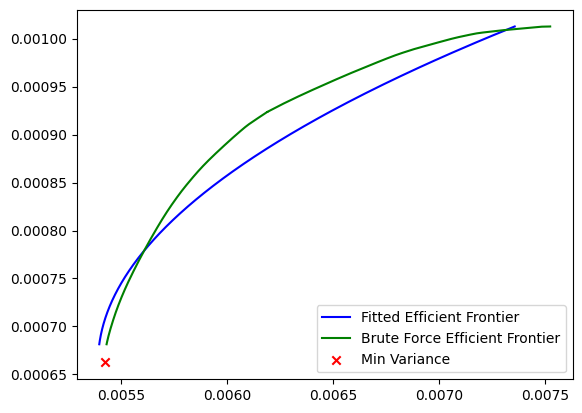

In [24]:
vol_hyperb = bs.optimization.fitted_f(np.array(bf_means))

plt.plot(vol_hyperb, bf_means, label="Fitted Efficient Frontier", c="b")
plt.plot(bf_vols, bf_means, label="Brute Force Efficient Frontier", c="g")
plt.scatter(
    bs.optimization.min_v_vol,
    bs.optimization.min_v_mu,
    c="r",
    label="Min Variance",
    marker="x",
)
plt.legend()
plt.show()

We see that our fit is quite far off - the optimal value of the tangent line to these two curves will be at way different levels. Thus, this parabola would be highly irrelevant for our optimization). Notice that `MinVariance` point does not lie on plotted curve - this is just due to `Brute-Force` estimate that does not obviously approach $risk\_aversion = +\inf$ in iterations.

The next idea might be to employ the Active Learning approach. While there exists a great approach for **Active Learning for polynomial functions by choosing maximum posterior uncertainty point (Sung & Niyogi, 1994)**, the optimization of maximum return for given volatility is out of the scope of this Backtesting Framework, so we try a simpler approach - sampling volatilities that correspond to maximum uncertainty of $f$ regions as an approximation.

In [25]:
class MaxSharpeHyperbolicActiveLearn(MaxSharpeGPActiveLearn, MaxSharpeHyperbolicApprox):
    def __init__(
        self,
        max_risk_aversion: float = 100.0,
        max_iterations: int = 10,
        turnover_penalty: Optional[float] = None,
        acq_beta: float = 1.96,
        constraints: Optional[Constraints] = None,
        covariance: Optional[Covariance] = None,
        expected_return: Optional[ExpectedReturn] = None,
        **kwargs,
    ) -> None:
        super().__init__(
            max_risk_aversion=max_risk_aversion,
            max_iterations=max_iterations,
            turnover_penalty=turnover_penalty,
            acq_beta=acq_beta,
            constraints=constraints,
            covariance=covariance,
            expected_return=expected_return,
            **kwargs,
        )

    def _run_search(self, max_ra: float, max_iter: int) -> tuple[float, np.ndarray]:
        _, min_v_mu, min_v_vol, _ = self._optimize_min_v()

        self.min_v_mu = min_v_mu
        self.min_v_vol = min_v_vol

        xdata = [min_v_mu]
        ydata = [min_v_vol]
        for _ in range(max_iter - 1):
            ra = self.next_recommendation()

            weights, mu, vol, sharpe = self._optimize_mv(ra)
            xdata.append(mu)
            ydata.append(vol)

            self.add_data_point(ra, sharpe, weights)

        xdata = np.array(xdata)
        ydata = np.array(ydata)

        params_opt, params_cov = curve_fit(
            self._efficient_frontier, xdata - self.min_v_mu, ydata
        )
        self.fitted_f = lambda x: self._efficient_frontier(
            x - self.min_v_mu, *params_opt
        )

        return None, weights

In [26]:
bs.optimization = MaxSharpeHyperbolicActiveLearn(
    covariance=Covariance(method="pearson"),
    expected_return=ExpectedReturn(method="geometric"),
    solver_name="cvxopt",  # <change this to your preferred solver>
    # <add any other parameters you need, e.g., number of iterations, tolerance, etc.>
)
bs.prepare_rebalancing("2015-01-02")
bs.optimization.set_objective(bs.optimization_data)
bs.optimization.solve()
bs.optimization.results

{'risk-aversion': None,
 'weights': {'102': 4.5073283024815534e-08,
  '103': 3.4151333993437447e-08,
  '104': 0.019999228952465153,
  '111': 0.014430700949425208,
  '113': 1.0687187192873495e-08,
  '122': 5.591214697713579e-08,
  '125': 0.01999995899711108,
  '127': 0.01999995411455773,
  '128': 0.019999903643502983,
  '13': 5.257967980459988e-08,
  '139': 0.019999849894199947,
  '141': 0.019999917605306717,
  '142': 3.81824613479811e-08,
  '148': 0.019999946721949522,
  '149': 4.541343788569245e-08,
  '154': 9.529674584883514e-08,
  '159': 0.019999928841830838,
  '161': 0.01960832859771272,
  '169': 0.019999957338982195,
  '175': 0.019999881823257643,
  '176': 0.019997733887890133,
  '177': 5.674132914675834e-08,
  '184': 0.01999990255081611,
  '185': 0.01999987350517788,
  '187': 5.443619687919181e-08,
  '189': 9.569893220954712e-08,
  '191': 0.01999832670043534,
  '197': 8.68943607859504e-08,
  '2': 0.019999896152159177,
  '200': 0.019995979997966568,
  '201': 0.007317845481703206,


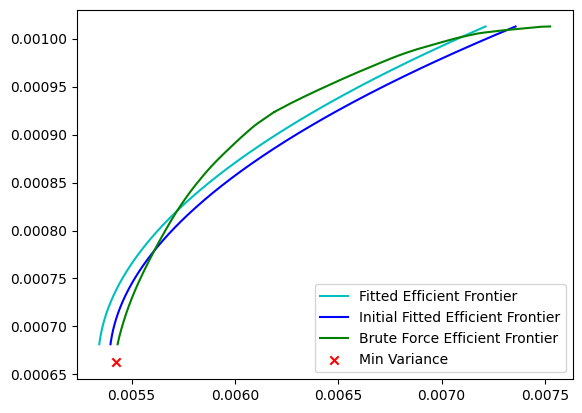

In [27]:
vol_hyperb_ac = bs.optimization.fitted_f(np.array(bf_means))

plt.plot(vol_hyperb_ac, bf_means, label="Fitted Efficient Frontier", c="c")
plt.plot(vol_hyperb, bf_means, label="Initial Fitted Efficient Frontier", c="b")
plt.plot(bf_vols, bf_means, label="Brute Force Efficient Frontier", c="g")
plt.scatter(
    bs.optimization.min_v_vol,
    bs.optimization.min_v_mu,
    c="r",
    label="Min Variance",
    marker="x",
)
plt.legend()
plt.show()

We see that while our fitted curve is indeed improved greatly, compared to Naiive equidistant approach, it still is quite far from actual Efficient Frontier.

Thus, the final optimization choice should be either `GoldenSection` or `GP With Active Learning`, as these two approaches have most sound theoretical and empirical results of all of our attempts.

b)

(2 points)

Provide a theoretical or empirical justification that your algorithm converges to the true maximum Sharpe ratio portfolio for the given coefficients of mean and covariance.
Hint: If you want to provide an empirical justification, you can perform an optimization for a single point in time by running the following code.

First of all, the `2. Golden Section` is asymptotically optimal under $O(log_{\phi}(\frac{max\_ra}{\epsilon}))$ (Mordecai & Douglass, 1966 - "Optimality proof for the symmetric Fibonacci search technique").

Therefore, our terminated at given number of iterations algorithm provides asymptotically bounded error $|ra^{\star} - \hat{ra}| \leq \frac{max\_ra}{\phi^{max\_iter}}$, which is increasing in upper bound for risk-aversion (if we do not know "plausible set") and decreasing in number of allowed iterations.

In [28]:
print(f"|ra^opt - ra^hat| <= {100 / MaxSharpeGoldenSection.GS_CONST**10:.4f}")

|ra^opt - ra^hat| <= 0.8131


The solution via `4. GP With Active Learning` has the error bound of $\tilde{O}(max\_iter ^ {\frac{5}{6}})$ for the square eigendecaying Kernel (Whitehouse, Ramdas, Wu, NeurIPS 2023), which is our case here (Kernel's $length\_scale = 1$), meaning that the error is $|ra^{\star} - \hat{ra}| <= max\_iter ^ {\frac{5}{6}})$.

In [29]:
print(f"|ra^opt - ra^hat| <= {10 ** (5 / 6):.4f}")

|ra^opt - ra^hat| <= 6.8129


We can see that our upper bound on error is way worse, which is expected, as **GP-UCB works for way more general setting of complex landscapes, for which this bound is derived**. However, empirically it still works pretty good, which we show in the run in section 1a).

All in all, our target method turns out to be very simple, but powerful `2. Golden Section`.

In [30]:
bs.optimization = MaxSharpeGoldenSection(
    covariance=Covariance(method="pearson"),
    expected_return=ExpectedReturn(method="geometric"),
    solver_name="cvxopt",
)
bs.prepare_rebalancing("2015-01-02")
bs.optimization.set_objective(bs.optimization_data)
bs.optimization.solve()
bs.optimization.results

Golden Section Search: 100%|██████████| 10/10 [00:00<00:00, 57.76it/s]


{'risk-aversion': np.float64(12.269241877260763),
 'weights': {'102': 1.0647795081150917e-07,
  '103': 6.833982932442565e-08,
  '104': 0.019999648407619457,
  '111': 0.018988575430585814,
  '113': 2.1793874553147394e-08,
  '122': 1.9305516206533883e-07,
  '125': 0.01999989790841647,
  '127': 0.019999879959771396,
  '128': 0.01999982756326809,
  '13': 1.494297570121157e-07,
  '139': 0.01999985480184441,
  '141': 0.019999914098335864,
  '142': 9.420110648815137e-08,
  '148': 0.019999903674760226,
  '149': 9.215400227849293e-08,
  '154': 1.6259231883735657e-07,
  '159': 0.01999969041967226,
  '161': 0.006894954858912076,
  '169': 0.019999911849393297,
  '175': 0.0199995816892402,
  '176': 0.019998501401455565,
  '177': 7.674339705541955e-08,
  '184': 0.019999752020049905,
  '185': 0.019999668585819207,
  '187': 1.3007972769111107e-07,
  '189': 3.678654584963181e-07,
  '191': 1.2198778637700048e-06,
  '197': 3.5570174721366213e-07,
  '2': 0.019998754946274174,
  '200': 0.019998919981269785

In [31]:
print(
    f"Brute Force Solution = {ra[sr_opt_idx]:.6f} vs Target Solution = {bs.optimization.results['risk-aversion']:.6f}"
)

Brute Force Solution = 12.212212 vs Target Solution = 12.269242


## 2. Backtest MaxSharpe with Turnover Penalty

(5 points)

Calibrate the turnover penalty parameter such that the backtest of the MaxSharpe strategy displays an annual turnover of roughly 100%.

First, let's note that the usual approach would involve a very complex landscape of $g: hyperparam -> metric$, for which we would employ the Bayesian Optimization with `optuna` (which does quite similar Optimization to Active Learning above). We leave the code for that approach here, however, our **target approach will be way simpler**.

In [32]:
# import optuna
#
# TARGET_TURNOVER = 1.0
# N_OPTUNA_TRIALS = 12
#
# rebal_dates = pd.to_datetime(pd.Series(rebdates))
# avg_annual_rebals = 365 // rebal_dates.diff()[1:].dt.days.mean()
#
# def objective(trial):
#     turnover_constr = trial.suggest_float('tau', 1e-12, 1e-1)
#
#     bs.optimization = MaxSharpeGoldenSection(
#         covariance=Covariance(method='pearson'),
#         expected_return=ExpectedReturn(method='geometric'),
#         solver_name='cvxopt',
#         turnover_penalty=turnover_constr,
#         verbose=False,
#     )
#
#     bt_ms = Backtest()
#     bt_ms.run(bs = bs)
#
#     realized_turnover = bt_ms.strategy.turnover(return_series = bs.data.get_return_series()).mean() * avg_annual_rebals
#
#     print(f"Tau = {turnover_constr:.4f}, Turnover: {realized_turnover:.4f}")
#
#     return (TARGET_TURNOVER - realized_turnover) ** 2
#
# study = optuna.create_study()
# study.optimize(objective, n_trials=N_OPTUNA_TRIALS)
#
# study.best_params

Let's note that our target is the turnover and the hyperparameter is the turnover constraint. Therefore, we have a **monotone dependence** for $g$ in this setting - the higher the penalty, the lower (or at least not higher) the average turnover almost everywhere (as we can always rebalance a bit more to shift the weights to more optimal point).

Thus, one can employ a very powerful **BinarySearch** algorithm, which works on sorted arrays to find maximum / minimum → **modified Binary Search** for **monotone functions optimization**. It is guaranteed to converge in at least $O(log(n))$ iterations, where $n$ is the Grid Size, controlled by precision hyperparameter.

The algorithm works as follows:
* Split the interval in half;
* Check the average turnover for mid-point;
* In case the turnover is less (larger) than target, we are allowed to shift penalty lower (higher);
* Therefore, optimum lies to the left (right) of mid-point;
* We iterate the algorithm due to optimality of half split (largest number of "useless" points in grid is dropped at each iteration).

In [33]:
TARGET_TURNOVER = 1.0
CONSTR_LOWER_BOUND = 1e-9
CONSTR_UPPER_BOUND = 1e-4

# Say that we are fine with 1% imprecision in turnover
PRECISION = 2

rebal_dates = pd.to_datetime(pd.Series(rebdates))
avg_annual_rebals = 365 // rebal_dates.diff()[1:].dt.days.mean()


def objective(turnover_constr: float) -> float:
    bs.optimization = MaxSharpeGoldenSection(
        covariance=Covariance(method="pearson"),
        expected_return=ExpectedReturn(method="geometric"),
        solver_name="cvxopt",
        turnover_penalty=turnover_constr,
        verbose=False,
    )

    bt_ms = Backtest()
    bt_ms.run(bs=bs)

    # Drop first point of turnover, as starting from (x_init = identically zeros) always induces 100% turnover
    realized_turnover = (
        bt_ms.strategy.turnover(return_series=bs.data.get_return_series())[1:].mean()
        * avg_annual_rebals
    )

    print(f"Tau = {turnover_constr:.8f}, Turnover: {realized_turnover:.4f}")

    return realized_turnover

In [34]:
def binary_search_turnover_penalty(
    constr_lower_bound: float = CONSTR_LOWER_BOUND,
    constr_upper_bound: float = CONSTR_UPPER_BOUND,
) -> float:
    left_restriction = constr_lower_bound
    right_restriction = constr_upper_bound

    step = (constr_upper_bound - constr_lower_bound) * 10 ** (-PRECISION)

    while left_restriction <= right_restriction:
        constr_guess = left_restriction + (right_restriction - left_restriction) / 2
        realized_turnover = objective(constr_guess)

        difference = realized_turnover - TARGET_TURNOVER

        if abs(difference) <= 10 ** (-PRECISION):
            return constr_guess
        elif difference > 0:
            left_restriction = constr_guess + step
        else:
            right_restriction = constr_guess - step

    return constr_guess

In [35]:
tau_opt = binary_search_turnover_penalty()
tau_opt

Rebalancing date: 2015-01-02
Rebalancing date: 2015-04-01
Rebalancing date: 2015-06-29
Rebalancing date: 2015-09-24
Rebalancing date: 2015-12-22
Rebalancing date: 2016-03-18
Rebalancing date: 2016-06-15
Rebalancing date: 2016-09-12
Rebalancing date: 2016-12-08
Rebalancing date: 2017-03-07
Rebalancing date: 2017-06-02
Rebalancing date: 2017-08-30
Rebalancing date: 2017-11-27
Rebalancing date: 2018-02-22
Rebalancing date: 2018-05-22
Rebalancing date: 2018-08-17
Rebalancing date: 2018-11-14
Rebalancing date: 2019-02-11
Rebalancing date: 2019-05-09
Rebalancing date: 2019-08-06
Rebalancing date: 2019-11-01
Rebalancing date: 2020-01-29
Rebalancing date: 2020-04-27
Rebalancing date: 2020-07-23
Rebalancing date: 2020-10-20
Rebalancing date: 2021-01-15
Rebalancing date: 2021-04-14
Rebalancing date: 2021-07-12
Rebalancing date: 2021-10-07
Rebalancing date: 2022-01-04
Rebalancing date: 2022-04-01
Rebalancing date: 2022-06-29
Rebalancing date: 2022-09-26
Rebalancing date: 2022-12-22
Rebalancing da

6.912530875e-05

In [36]:
# Update the backtest service with a MaxSharpe optimization object
bs.optimization = MaxSharpeGoldenSection(
    covariance=Covariance(method="pearson"),
    expected_return=ExpectedReturn(method="geometric"),
    solver_name="cvxopt",
    turnover_penalty=tau_opt,
)

# Instantiate the backtest object
bt_ms = Backtest()

# Run the backtest
bt_ms.run(bs=bs)
bt_ms.strategy.turnover(return_series=bs.data.get_return_series())[
    1:
].mean() * avg_annual_rebals

Rebalancing date: 2015-01-02


Golden Section Search: 100%|██████████| 10/10 [00:00<00:00, 13.20it/s]


Rebalancing date: 2015-04-01


Golden Section Search: 100%|██████████| 10/10 [00:00<00:00, 11.58it/s]


Rebalancing date: 2015-06-29


Golden Section Search: 100%|██████████| 10/10 [00:00<00:00, 11.50it/s]


Rebalancing date: 2015-09-24


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Rebalancing date: 2015-12-22


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


Rebalancing date: 2016-03-18


Golden Section Search: 100%|██████████| 10/10 [00:00<00:00, 10.86it/s]


Rebalancing date: 2016-06-15


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Rebalancing date: 2016-09-12


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Rebalancing date: 2016-12-08


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


Rebalancing date: 2017-03-07


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


Rebalancing date: 2017-06-02


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


Rebalancing date: 2017-08-30


Golden Section Search: 100%|██████████| 10/10 [00:00<00:00, 10.48it/s]


Rebalancing date: 2017-11-27


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


Rebalancing date: 2018-02-22


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Rebalancing date: 2018-05-22


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Rebalancing date: 2018-08-17


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


Rebalancing date: 2018-11-14


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Rebalancing date: 2019-02-11


Golden Section Search: 100%|██████████| 10/10 [00:00<00:00, 10.82it/s]


Rebalancing date: 2019-05-09


Golden Section Search: 100%|██████████| 10/10 [00:00<00:00, 10.27it/s]


Rebalancing date: 2019-08-06


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Rebalancing date: 2019-11-01


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Rebalancing date: 2020-01-29


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Rebalancing date: 2020-04-27


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Rebalancing date: 2020-07-23


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Rebalancing date: 2020-10-20


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


Rebalancing date: 2021-01-15


Golden Section Search: 100%|██████████| 10/10 [00:00<00:00, 10.37it/s]


Rebalancing date: 2021-04-14


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  9.75it/s]


Rebalancing date: 2021-07-12


Golden Section Search: 100%|██████████| 10/10 [00:00<00:00, 10.35it/s]


Rebalancing date: 2021-10-07


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


Rebalancing date: 2022-01-04


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


Rebalancing date: 2022-04-01


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s]


Rebalancing date: 2022-06-29


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Rebalancing date: 2022-09-26


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


Rebalancing date: 2022-12-22


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Rebalancing date: 2023-03-21


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


Rebalancing date: 2023-06-16


Golden Section Search: 100%|██████████| 10/10 [00:00<00:00, 10.59it/s]


Rebalancing date: 2023-09-13


Golden Section Search: 100%|██████████| 10/10 [00:00<00:00, 10.16it/s]


Rebalancing date: 2023-12-11


Golden Section Search: 100%|██████████| 10/10 [00:00<00:00, 10.84it/s]


Rebalancing date: 2024-03-07


Golden Section Search: 100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


np.float64(1.0032692846625242)

## 3. Simulation and Descriptive Statistics

(3 points)

- Simulate the portfolio returns from your MaxSharpe backtest. Use fixed costs of 1% and variable costs of 0.3%.
- Plot the cumulated returns of the MaxSharpe strategy together with those of the SPI Index.
- Plot the turnover of your MaxSharpe strategy over time.
- Print the annualized turnover (computed as the average turnover over the backtest multiplied by the number of rebalancing per year) for your MaxSharpe strategy.
- Create and print a table with descriptive performance statistics for your MaxSharpe strategy and the SPI Index.


Add `MeanVariance` optimization to compare against our `MaxSharpe` logic.

In [37]:
bs_mv = deepcopy(bs)

bs_mv.optimization = MeanVariance(
    covariance=Covariance(method="pearson"),
    expected_return=ExpectedReturn(method="geometric"),
    solver_name="cvxopt",
    turnover_penalty=tau_opt,
    risk_aversion=1.0,
)

# Instantiate the backtest object
bt_mv = Backtest()

# Run the backtest
bt_mv.run(bs=bs_mv)
bt_mv.strategy.turnover(return_series=bs_mv.data.get_return_series())[
    1:
].mean() * avg_annual_rebals

Rebalancing date: 2015-01-02
Rebalancing date: 2015-04-01
Rebalancing date: 2015-06-29
Rebalancing date: 2015-09-24
Rebalancing date: 2015-12-22
Rebalancing date: 2016-03-18
Rebalancing date: 2016-06-15
Rebalancing date: 2016-09-12
Rebalancing date: 2016-12-08
Rebalancing date: 2017-03-07
Rebalancing date: 2017-06-02
Rebalancing date: 2017-08-30
Rebalancing date: 2017-11-27
Rebalancing date: 2018-02-22
Rebalancing date: 2018-05-22
Rebalancing date: 2018-08-17
Rebalancing date: 2018-11-14
Rebalancing date: 2019-02-11
Rebalancing date: 2019-05-09
Rebalancing date: 2019-08-06
Rebalancing date: 2019-11-01
Rebalancing date: 2020-01-29
Rebalancing date: 2020-04-27
Rebalancing date: 2020-07-23
Rebalancing date: 2020-10-20
Rebalancing date: 2021-01-15
Rebalancing date: 2021-04-14
Rebalancing date: 2021-07-12
Rebalancing date: 2021-10-07
Rebalancing date: 2022-01-04
Rebalancing date: 2022-04-01
Rebalancing date: 2022-06-29
Rebalancing date: 2022-09-26
Rebalancing date: 2022-12-22
Rebalancing da

np.float64(0.9761568100010338)

In [38]:
fixed_costs = 0.01
variable_costs = 0.003
return_series = bs.data.get_return_series()

simulated_data = {
    "benchmark": bs.data.bm_series,
    "mean_var": bt_mv.strategy.simulate(
        return_series=return_series,
        fc=fixed_costs,
        vc=variable_costs,
    ),
    "max_sharpe": bt_ms.strategy.simulate(
        return_series=return_series,
        fc=fixed_costs,
        vc=variable_costs,
    ),
}
simulated = pd.concat(simulated_data, axis=1).dropna()

/Users/buchkovv/PycharmProjects/uzh/qpmp/qpmwp-course/src/backtesting/strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
/Users/buchkovv/PycharmProjects/uzh/qpmp/qpmwp-course/src/backtesting/strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]
/Users/buchkovv/PycharmProjects/uzh/qpmp/qpmwp-course/src/backtesting/strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

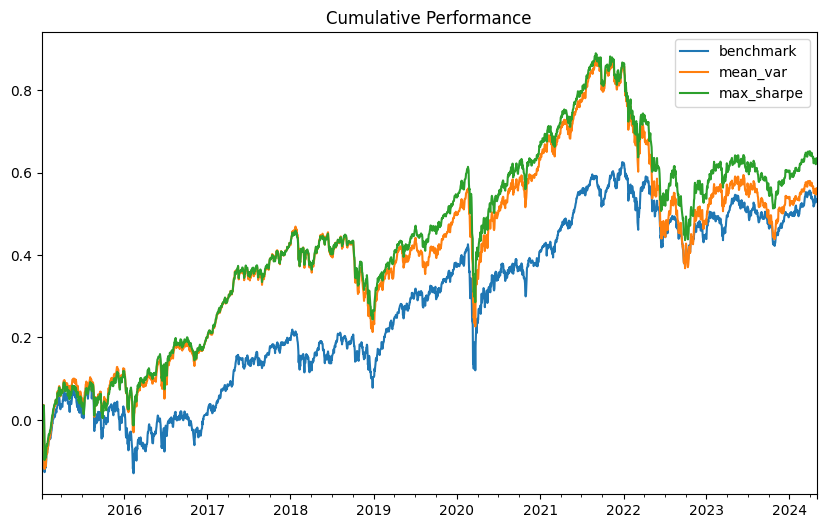

In [39]:
np.log((1 + simulated)).cumsum().plot(title="Cumulative Performance", figsize=(10, 6));

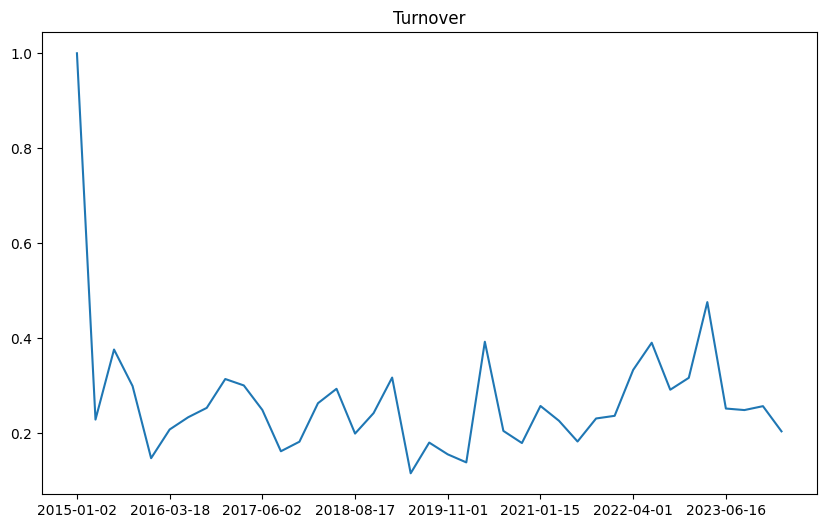

In [40]:
turnover = pd.Series(
    bt_ms.strategy.turnover(return_series=return_series), name="max_sharpe_turnover"
).dropna()

turnover.plot(title="Turnover", figsize=(10, 6));

In [41]:
avg_turnover = (
    bt_ms.strategy.turnover(return_series=bs.data.get_return_series())[1:].mean()
    * avg_annual_rebals
)
print(f"Average Annualized Turnover = {avg_turnover * 100:.2f}%")

Average Annualized Turnover = 100.33%


In [42]:
class Assessor:
    N_DAYS_PER_YEAR: int = 252

    def __init__(self, rf_rate: pd.Series) -> None:
        self.rf_rate = rf_rate

    @staticmethod
    def _get_max_drawdown(total_returns: pd.DataFrame) -> np.ndarray:
        total_nav = total_returns.add(1).cumprod(axis=0)
        prev_peak = total_nav.cummax(axis=0)

        return ((total_nav - prev_peak) / prev_peak).min(axis=0)

    def _run(self, strategies_total_r: pd.DataFrame) -> pd.DataFrame:
        factor_annual = (
            self.N_DAYS_PER_YEAR // strategies_total_r.index.diff().min().days
        )
        n_periods = strategies_total_r.shape[0] / factor_annual

        final_nav = strategies_total_r.add(1).prod(axis=0)
        final_rf = self.rf_rate.add(1).prod(axis=0)

        strat_mean = final_nav ** (1 / n_periods) - 1
        rf_mean = final_rf ** (1 / n_periods) - 1

        strat_std = strategies_total_r.std(axis=0) * np.sqrt(factor_annual)

        sharpe_ratio = (strat_mean - rf_mean) / strat_std

        strategy_max_dd = self._get_max_drawdown(strategies_total_r)

        metrics = pd.DataFrame(index=strategies_total_r.columns)
        metrics.loc[:, "Cumulative Return"] = final_nav.cumprod() - 1
        metrics.loc[:, "Annualized Average Returns"] = strat_mean * 100
        metrics.loc[:, "Annualized Volatility"] = strat_std * 100
        metrics.loc[:, "Sharpe Ratio"] = sharpe_ratio
        metrics.loc[:, "Maximum Drawdown"] = strategy_max_dd * 100

        return metrics

    def __call__(self, strategies_total_r: pd.DataFrame) -> pd.DataFrame:
        return self._run(strategies_total_r)


assessor = Assessor(rf_rate=pd.Series(index=simulated.index, data=0.03 / 365))
strat_metrics = assessor(simulated)
strat_metrics

,Cumulative Return,Annualized Average Returns,Annualized Volatility,Sharpe Ratio,Maximum Drawdown
benchmark,0.701100,5.659331,14.569010,0.244806,-26.328923
mean_var,1.960356,5.908804,15.721631,0.242727,-39.880159
max_sharpe,4.550575,6.730172,14.291070,0.324498,-36.430191


We can see that `MaxSharpe` portfolio outperforms both the benchmark and the `MeanVariance` portfolio.

One small note is that our turnover constraint search was actually done In-Sample, not Out-Of-Sample. It means that if optimality comes from good turnover constraint, one might actually produce not that optimal rebalancing at market inflection points in practice - if market was quite volatile, our estimates are also volatile => our actual rebalancing would be higher, but we leak the information from the realized future turnover, allowing for slightly higher turnover in 2020 after market drop (as the chart for Turnover shows), because we "know" that in the rest of the year it won't be as large. However, in general, **doing it fully correctly seems overly complicated and it should not affect robustness of performance**.